In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from sklearn.preprocessing import MinMaxScaler

# Timeseries

from statsmodels.tsa.stattools import adfuller

# Connect to SQL database
import sqlite3
connex = sqlite3.connect('bixi_data.db')  
cur = connex.cursor()

In [2]:
# Import tables

df_bixi = pd.read_sql_query("SELECT * FROM bixi", connex)
df_weather = pd.read_sql_query("SELECT * FROM weather", connex)
df_holiday = pd.read_sql_query("SELECT * FROM holiday", connex)
df_stations = pd.read_sql_query("SELECT * FROM stations",connex)

In [3]:
def describe_df(df):
    print(f'{df.head(2)}\n')
    print(f'{df.info()}\n')
    print(f'shape: {df.shape} \n')
    print(f'Number of null values: \n{df.isnull().sum()}\n')
    print(f'Number of duplicate rows: {df.duplicated().sum()}')

In [4]:
describe_df(df_bixi)

         start_date  start_station_code          end_date  end_station_code  \
0  2018-04-10 11:56                7030  2018-04-10 11:57              6141   
1  2018-04-10 11:56                6100  2018-04-10 11:59              6064   

   duration_sec  is_member  
0            87          1  
1           122          1  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5277541 entries, 0 to 5277540
Data columns (total 6 columns):
start_date            object
start_station_code    int64
end_date              object
end_station_code      int64
duration_sec          int64
is_member             int64
dtypes: int64(4), object(2)
memory usage: 241.6+ MB
None

shape: (5277541, 6) 

Number of null values: 
start_date            0
start_station_code    0
end_date              0
end_station_code      0
duration_sec          0
is_member             0
dtype: int64

Number of duplicate rows: 6103


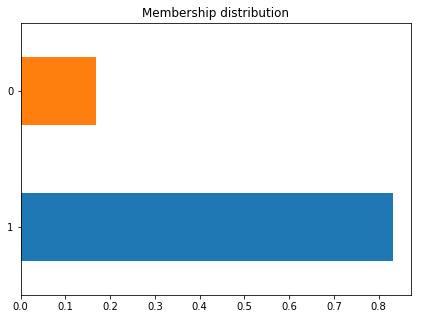

In [5]:
# Membership distribution
df_bixi.is_member.value_counts(normalize = True).plot.barh(title = 'Membership distribution', figsize = (7,5))

1 - Extract from Start_date and End_date date, hour, minute. Add day of the week as feature

In [6]:
# Extract date, hour, minute and day of the week for start date

df_bixi['start_date'] = pd.to_datetime(df_bixi['start_date'])
df_bixi['start_datetime'] = df_bixi['start_date']
df_bixi['start_month'] = df_bixi['start_date'].dt.month
df_bixi['start_hour'] = df_bixi['start_date'].dt.hour
df_bixi['start_weekday'] = df_bixi['start_date'].dt.dayofweek
df_bixi['start_date'] = df_bixi['start_date'].dt.date

# Repeat process for End timestamp

# df_bixi['end_date'] = pd.to_datetime(df_bixi['end_date'])
# df_bixi['end_datetime'] = df_bixi['end_date']
# df_bixi['end_month'] = df_bixi['end_date'].dt.month
# df_bixi['end_hour'] = df_bixi['end_date'].dt.hour
# df_bixi['end_weekday'] = df_bixi['end_date'].dt.dayofweek
# df_bixi['end_date'] = df_bixi['end_date'].dt.date

In [7]:
df_bixi = df_bixi[df_bixi['start_date'] != datetime.date(2018, 4, 10)] # Drop incomplete days
df_bixi = df_bixi[df_bixi['start_date'] != datetime.date(2018, 11, 15)] # Drop incomplete days
df_bixi = df_bixi[df_bixi['duration_sec'] > 120] # Retaining trips longer than 2 minutes
# df_bixi = df_bixi[df_bixi['start_weekday'] < 5] # Retaining trips taken during weekdays

In [8]:
df_bixi = df_bixi.reset_index().drop(['index'], axis = 1) # Reset index

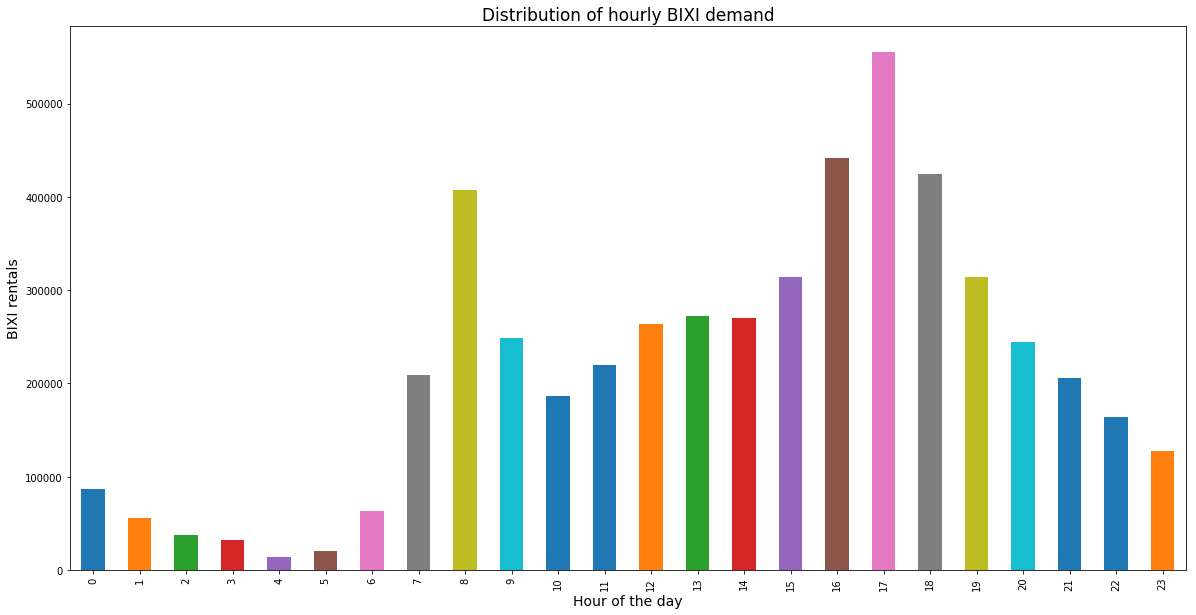

In [9]:
# Demand by hour (0 = From Midnight to 1AM)
grouped_hour = df_bixi.groupby(df_bixi['start_hour']).count().reset_index()
grouped_hour = grouped_hour[['start_hour','start_date']]
grouped_hour.rename(columns = {'start_date':'count'}, inplace = True)
ax_hour = grouped_hour.plot.bar(x = 'start_hour', y = 'count', figsize=(20,10))
ax_hour.set_xlabel('Hour of the day', fontsize=14)
ax_hour.set_ylabel('BIXI rentals', fontsize=14)
ax_hour.set_title("Distribution of hourly BIXI demand", fontsize=17)
ax_hour.get_legend().remove()

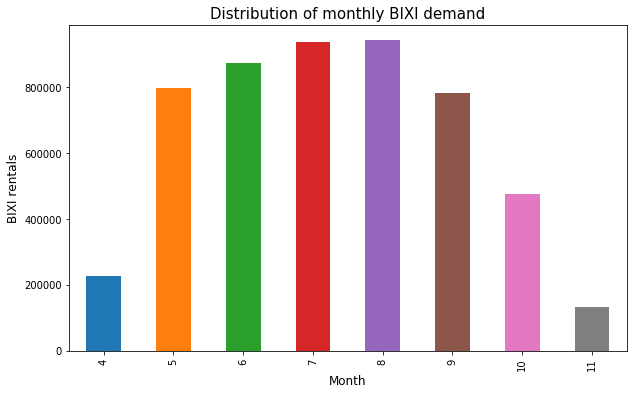

In [10]:
# Average Demand by month
grouped_month = df_bixi.groupby(df_bixi['start_month']).count().reset_index()
grouped_month = grouped_month[['start_month','start_date']]
grouped_month.rename(columns = {'start_date':'count'}, inplace = True)
ax_month = grouped_month.plot.bar(x = 'start_month', y = 'count', figsize=(10,6))
ax_month.set_xlabel('Month', fontsize=12)
ax_month.set_ylabel('BIXI rentals', fontsize=12)
ax_month.set_title("Distribution of monthly BIXI demand", fontsize=15)
ax_month.get_legend().remove()

Text(0.5, 1.0, 'Distribution of BIXI demand by day of the week')

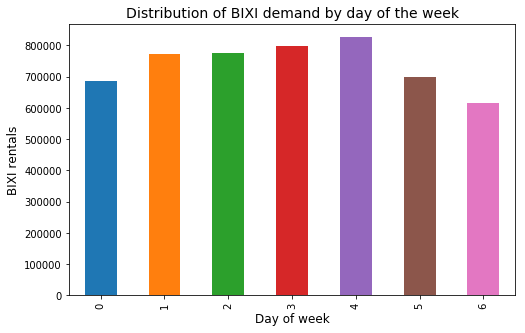

In [11]:
# Demand by day of the week (0 = Monday)

df_by_day = pd.DataFrame(df_bixi.groupby('start_weekday').count()['start_date']).rename(columns = {'start_date':'# Bixi rentals'})
ax_day = df_by_day.reset_index().plot.bar(x = 'start_weekday', y = '# Bixi rentals', figsize=(8,5))
ax_day.get_legend().remove()
ax_day.set_xlabel("Day of week", fontsize=12)
ax_day.set_ylabel("BIXI rentals", fontsize=12)
ax_day.set_title("Distribution of BIXI demand by day of the week", fontsize=14)

In [12]:
# To group by date & hour
df_bixi['date_hour'] = df_bixi['start_datetime'].apply(lambda x: x.replace(minute=0))

In [13]:
def heat_withtime():
    scaler = MinMaxScaler()
    df_bixi_hm = df_bixi.rename({'start_station_code':'code'}, axis = 1).merge(df_stations)
    df_bixi_hm['count'] = 1
    
    df_hour_list = []
    for hour in list(range(0,24)):
        df = df_bixi_hm.loc[df_bixi_hm.start_hour == hour, ['latitude', 'longitude','count']]
        df = df.groupby(['latitude', 'longitude']).sum()
        df['count'] = scaler.fit_transform(df)
        df_hour_list.append(df.reset_index().values.tolist())

    mtl_coordinates = (45.527616, -73.589115)

    # create empty map
    m = folium.Map(location=mtl_coordinates, zoom_start=11.5, tiles = 'stamenterrain')
    HeatMapWithTime(df_hour_list, index = list(range(0,24)), radius = 15,
                    min_opacity= 0.5, max_opacity=1,
                    gradient={0.001: 'blue', 0.05: 'green', 0.1: 'orange', 0.5: 'red', 0.9: 'darkred'}).add_to(m)
    return m

In [18]:
heat_withtime()

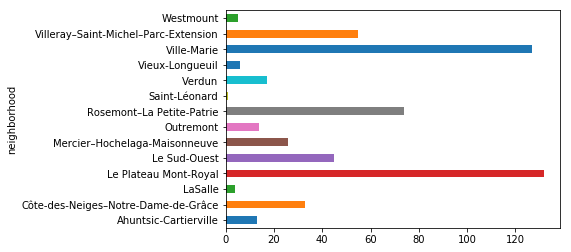

In [19]:
df_stations.groupby('neighborhood').count().code.plot.barh()

In [24]:
# Morning departures

df_morning = df_bixi
# df_bystation = df_bixi.groupby('start_station_code').count().reset_index()
df_morning = df_morning[df_morning['start_hour'] <= 11]
df_morning = df_morning[df_morning['start_hour'] >= 5]

df_mcount = pd.DataFrame(df_morning.groupby('start_station_code').count().sort_values('start_date', ascending = False).start_date)
df_mcount = df_mcount.reset_index().rename({'start_station_code':'code', 'start_date': 'count'}, axis = 1)
df_mcount = df_mcount.merge(df_stations)

# convert to (n, 2) nd-array format for heatmap
arr = df_mcount[['latitude', 'longitude']].values

mtl_coordinates = (45.527616, -73.589115)
  
# create empty map
m = folium.Map(location=mtl_coordinates, zoom_start=11.5, tiles = 'stamenterrain')
 
# add a marker
for row in df_mcount.iterrows():
    folium.CircleMarker(location = [row[1]['latitude'],row[1]['longitude']],
                 popup = row[1]['location'],
                 radius = row[1]['count']/10000,
                 fill=True).add_to(m)
m.add_child(HeatMap(arr, radius=15))
m

In [14]:
df_bixi_byhour = df_bixi.set_index('date_hour').reset_index()
df_bixi_byhour = pd.DataFrame(df_bixi_byhour.groupby('date_hour').count()['start_date']).rename(columns = {'start_date':'# Bixi rentals'})

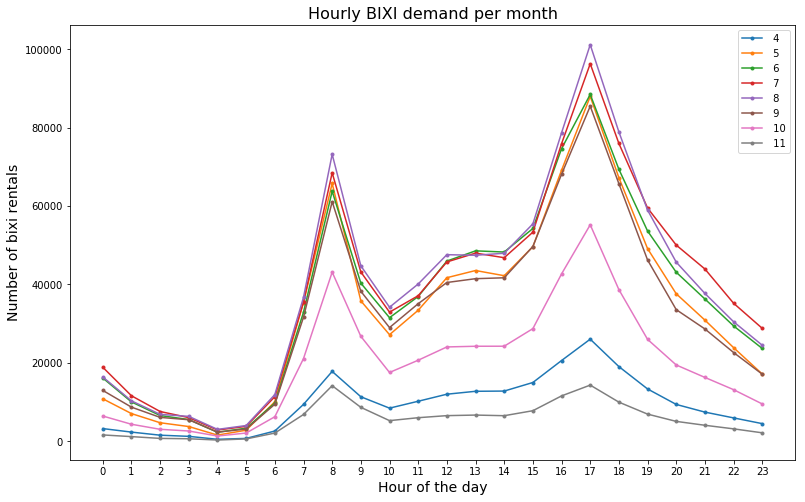

In [15]:
df_mth = df_bixi_byhour.groupby([(df_bixi_byhour.index.hour.values),(df_bixi_byhour.index.month.values)]).sum().unstack()

ax_mth = df_mth.plot(figsize = (13,8),subplots = False, marker = '.')
ax_mth.set_xlabel('Hour of the day', size =14)
ax_mth.set_xticks(range(0,24))
ax_mth.set_ylabel('Number of bixi rentals',size =14)
ax_mth.set_title('Hourly BIXI demand per month', size =16)
handles, labels = ax_mth.get_legend_handles_labels()
labels_new = [label.strip('()').split(',')[1] for label in labels]
plt.legend(handles, labels_new)

Text(0, 0.5, 'Day of the week')

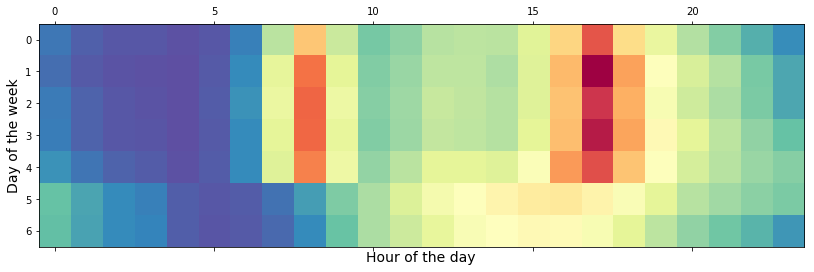

In [48]:
# Day of week usage vs hour of the day

df_day_hour = df_bixi_byhour.groupby([(df_bixi_byhour.index.hour),(df_bixi_byhour.index.dayofweek.values)]).sum().unstack()
plt.matshow(df_day_hour.T, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
plt.xlabel('Hour of the day', size = 14)
plt.ylabel('Day of the week', size = 14)


#### Weather

In [19]:
df_weather.uv_desc.value_counts()

Low          4288
Moderate      809
High          407
Very High     195
Name: uv_desc, dtype: int64

In [20]:
df_weather.condition.value_counts()

Fair            5576
Fair / Windy     123
Name: condition, dtype: int64

In [43]:
df_weather[df_weather.wind_speed >37]

date_hour day_ind  feels_like  heat_index  precip_hrly  \
3520  2018-08-29 15:00:00       D          83          83          0.0   

      humidity  temp   uv_desc  uv_index  wind_speed     condition  
3520        67    80  Moderate         5          38  Fair / Windy

In [44]:
df_weather[df_weather.condition == 'Fair / Windy']

date_hour day_ind  feels_like  heat_index  precip_hrly  \
7     2018-04-01 07:00:00       D          28          39         0.00   
8     2018-04-01 08:00:00       D          25          37         0.00   
9     2018-04-01 09:00:00       D          23          35         0.01   
10    2018-04-01 10:00:00       D          23          35         0.00   
11    2018-04-01 11:00:00       D          22          35         0.00   
12    2018-04-01 12:00:00       D          24          35         0.00   
87    2018-04-04 16:00:00       D          35          44         0.00   
88    2018-04-04 17:00:00       D          34          44         0.00   
89    2018-04-04 18:00:00       D          31          41         0.00   
90    2018-04-04 19:00:00       D          25          38         0.00   
92    2018-04-04 21:00:00       N          16          29         0.01   
93    2018-04-04 22:00:00       N          10          26         0.00   
94    2018-04-04 23:00:00       N           6          24         0.00   
95    2018-04-05 00:00:00       N           5          22         0.00   
96    2018-04-05 01:00:00       N           2          20         0.01   
97    2018-04-05 02:00:00       N           1          19         0.00   
98    2018-04-05 03:00:00       N           1          18         0.00   
99    2018-04-05 04:00:00       N          -2          16         0.00   
101   2018-04-05 06:00:00       D          -3          15         0.00   
103   2018-04-05 08:00:00       D          -2          15         0.00   
104   2018-04-05 09:00:00       D          -1          16         0.00   
105   2018-04-05 10:00:00       D          -2          16         0.00   
106   2018-04-05 11:00:00       D           0          18         0.00   
107   2018-04-05 12:00:00       D           2          20         0.00   
108   2018-04-05 13:00:00       D           6          22         0.00   
109   2018-04-05 14:00:00       D           9          24         0.00   
110   2018-04-05 15:00:00       D          10          25         0.00   
111   2018-04-05 16:00:00       D          10          25         0.00   
113   2018-04-05 18:00:00       D          12          26         0.00   
149   2018-04-07 06:00:00       D          18          30         0.00   
...                   ...     ...         ...         ...          ...   
5050  2018-11-03 17:00:00       D          31          41         0.00   
5054  2018-11-03 21:00:00       N          28          38         0.00   
5130  2018-11-07 00:00:00       N          51          51         0.00   
5133  2018-11-07 03:00:00       N          52          52         0.00   
5134  2018-11-07 04:00:00       N          52          52         0.00   
5135  2018-11-07 05:00:00       N          51          51         0.00   
5136  2018-11-07 06:00:00       N          51          51         0.00   
5139  2018-11-07 09:00:00       D          51          51         0.00   
5140  2018-11-07 10:00:00       D          52          52         0.00   
5143  2018-11-07 13:00:00       D          53          53         0.00   
5148  2018-11-07 18:00:00       N          40          47         0.00   
5214  2018-11-10 12:00:00       D          27          38         0.00   
5215  2018-11-10 13:00:00       D          28          39         0.00   
5216  2018-11-10 14:00:00       D          24          37         0.00   
5217  2018-11-10 15:00:00       D          24          36         0.00   
5218  2018-11-10 16:00:00       D          23          35         0.00   
5219  2018-11-10 17:00:00       N          22          35         0.00   
5220  2018-11-10 18:00:00       N          22          34         0.00   
5221  2018-11-10 19:00:00       N          20          33         0.00   
5222  2018-11-10 20:00:00       N          19          32         0.00   
5224  2018-11-10 22:00:00       N          17          31         0.00   
5225  2018-11-10 23:00:00       N          18          31         0.00   
5227  2018-11-11 01:

In [40]:
df_weather[df_weather.feels_like > 90]

date_hour day_ind  feels_like  heat_index  precip_hrly  \
2142  2018-06-30 16:00:00       D          91          91         0.00   
2143  2018-06-30 17:00:00       D          93          93         0.00   
2144  2018-06-30 18:00:00       D          91          91         0.00   
2145  2018-06-30 19:00:00       D          93          93         0.00   
2146  2018-06-30 20:00:00       D          91          91         0.00   
2161  2018-07-01 11:00:00       D          92          92         0.00   
2162  2018-07-01 12:00:00       D          95          95         0.00   
2163  2018-07-01 13:00:00       D          96          96         0.00   
2164  2018-07-01 14:00:00       D          97          97         0.00   
2165  2018-07-01 15:00:00       D          97          97         0.00   
2166  2018-07-01 16:00:00       D          97          97         0.00   
2167  2018-07-01 17:00:00       D         100         100         0.00   
2168  2018-07-01 18:00:00       D         101         101         0.00   
2169  2018-07-01 19:00:00       D         102         102         0.00   
2170  2018-07-01 20:00:00       D          99          99         0.00   
2171  2018-07-01 21:00:00       N          96          96         0.00   
2172  2018-07-01 22:00:00       N          96          96         0.00   
2173  2018-07-01 23:00:00       N          95          95         0.00   
2174  2018-07-02 00:00:00       N          93          93         0.00   
2184  2018-07-02 10:00:00       D          91          91         0.00   
2185  2018-07-02 11:00:00       D          95          95         0.00   
2186  2018-07-02 12:00:00       D          98          98         0.00   
2187  2018-07-02 13:00:00       D          98          98         0.00   
2188  2018-07-02 14:00:00       D          99          99         0.00   
2189  2018-07-02 15:00:00       D         100         100         0.00   
2190  2018-07-02 16:00:00       D         100         100         0.00   
2191  2018-07-02 17:00:00       D          99          99         0.00   
2237  2018-07-04 15:00:00       D          91          91         0.00   
2238  2018-07-04 16:00:00       D          93          93         0.00   
2239  2018-07-04 17:00:00       D          92          92         0.00   
...                   ...     ...         ...         ...          ...   
2266  2018-07-05 20:00:00       D          95          95         0.00   
2267  2018-07-05 21:00:00       N          94          94         0.00   
2268  2018-07-05 22:00:00       N          91          91         0.00   
2269  2018-07-05 23:00:00       N          91          91         0.00   
2527  2018-07-16 17:00:00       D          91          91         0.00   
3007  2018-08-06 13:00:00       D          91          91         0.00   
3008  2018-08-06 14:00:00       D          93          93         0.00   
3009  2018-08-06 15:00:00       D          94          94         0.00   
3010  2018-08-06 16:00:00       D          94          94         0.00   
3011  2018-08-06 17:00:00       D          95          95         0.00   
3012  2018-08-06 18:00:00       D          94          94         0.00   
3013  2018-08-06 19:00:00       D          91          91         0.00   
3494  2018-08-28 13:00:00       D          91          91         0.00   
3495  2018-08-28 14:00:00       D          94          94         0.00   
3496  2018-08-28 15:00:00       D          93          93         0.17   
3498  2018-08-28 17:00:00       D          92          92         0.06   
3499  2018-08-28 18:00:00       D          91          91         0.00   
3517  2018-08-29 12:00:00       D          93          93         0.00   
3518  2018-08-29 13:00:00       D          92          92         0.00   
3519  2018-08-29 14:00:00       D          95          95         0.00   
3638  2018-09-03 13:00:00       D          92          92         0.00   
3639  2018-09-03 14:00:00       D          92          92         0.13   
3640  2018-09-03 15:

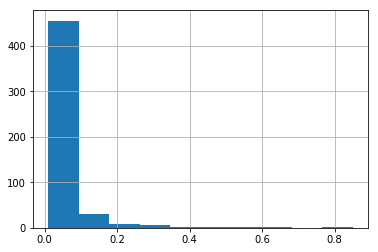

In [36]:
df_weather[df_weather.precip_hrly !=0].precip_hrly.hist()

In [51]:
df_weather['date_hour'] = pd.to_datetime(df_weather['date_hour'])

In [52]:
df_bixi.drop(['end_station_code','start_datetime','end_date'], axis =1, inplace =True)

In [53]:
df_member = df_bixi.groupby('date_hour').sum()['is_member'].reset_index()
df = df_bixi_byhour.merge(df_weather, on = 'date_hour').merge(df_member, on = 'date_hour')
df['casual'] = df['# Bixi rentals'] - df['is_member']

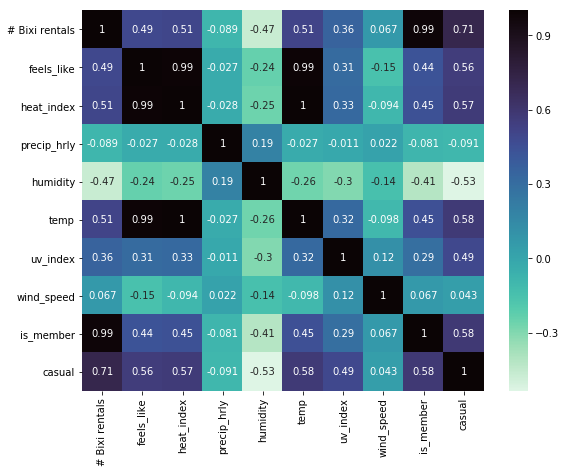

In [74]:
# To identify patterns in usage for casual vs members
# There is a slight difference in behaviour depending on the temperature, heat_index and feels like temperature

plt.figure(figsize = (9,7))
sns.heatmap(df.corr(), annot = True, cmap ='mako_r')

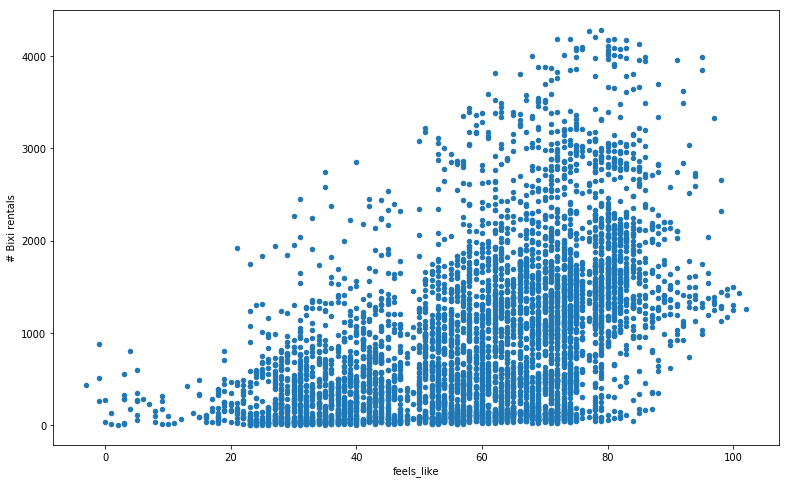

In [80]:
df.plot.scatter(x = 'feels_like', y ='# Bixi rentals', figsize = (13,8))

In [ ]:
df.plot.hist(x = 'precip_hrly', y ='# Bixi rentals', figsize = (13,8))

### Time Series analysis

In [108]:
rolmean = df_bixi_byhour['04-2018'].rolling(window = 24, center = False).mean()
rolstd = df_bixi_byhour['04-2018'].rolling(window = 24, center = False).std()

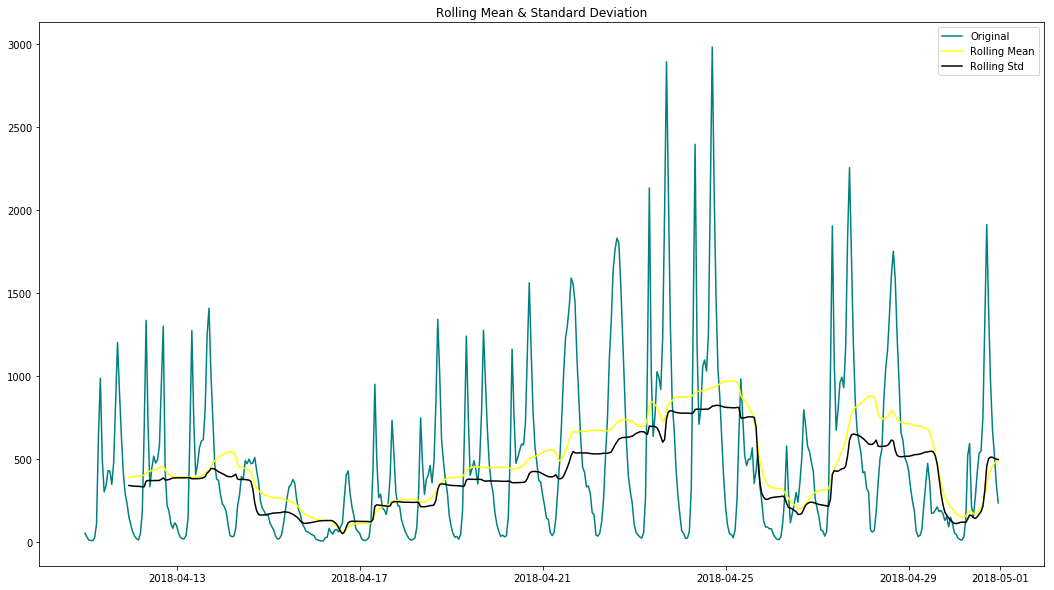

In [109]:
fig = plt.figure(figsize=(18,10))
orig = plt.plot(df_bixi_byhour['04-2018'], color='teal',label='Original')
mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

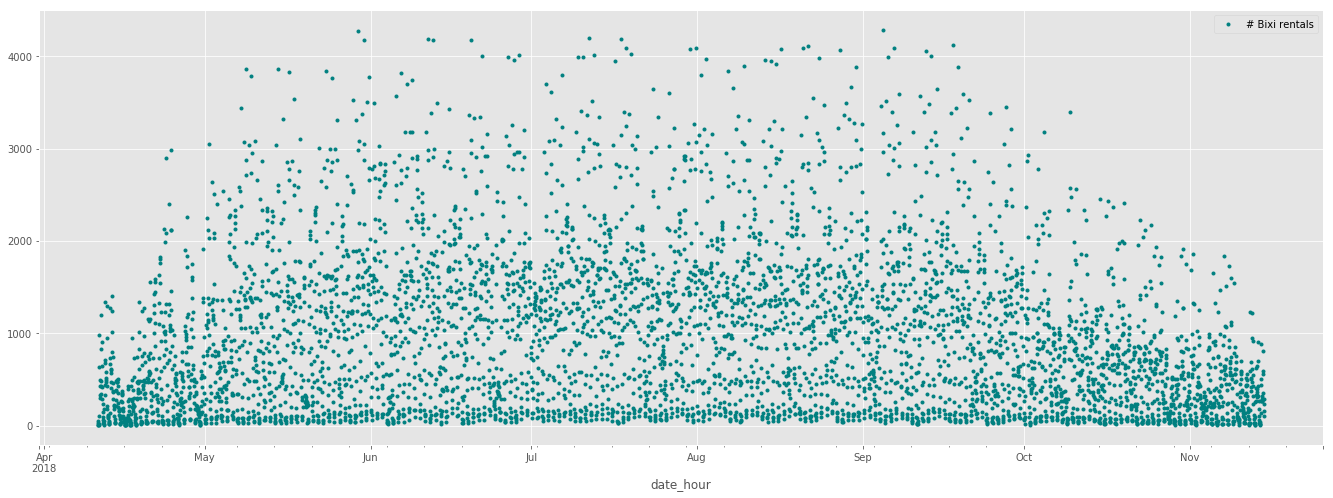

In [63]:
df_bixi_byhour.plot(figsize=(23,8), c = 'teal', style = '.b')

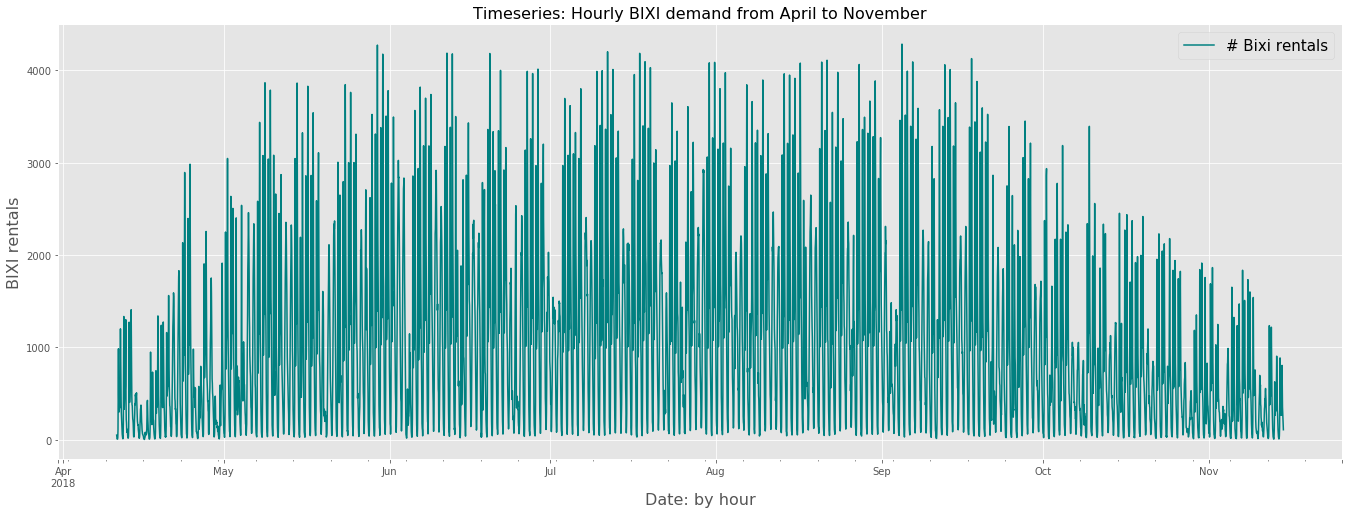

In [21]:
# Timeseries plot by hour
plt.style.use('ggplot')
ax = df_bixi_byhour.plot(figsize=(23,8), c = 'teal')
ax.set_ylabel("BIXI rentals", fontsize=16)
ax.set_xlabel("Date: by hour", fontsize=16)
ax.set_title('Timeseries: Hourly BIXI demand from April to November', fontsize=16)
ax.legend(fontsize = 15)
plt.show()

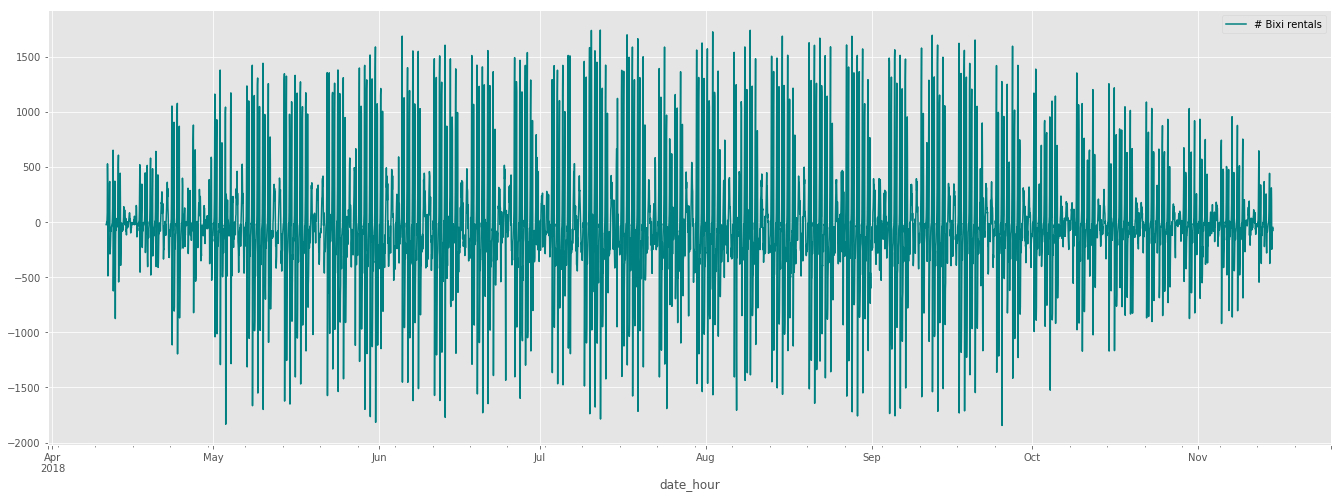

In [27]:
df_bixi_byhour.diff(periods = 1).plot(figsize = (23,8), c = 'teal')

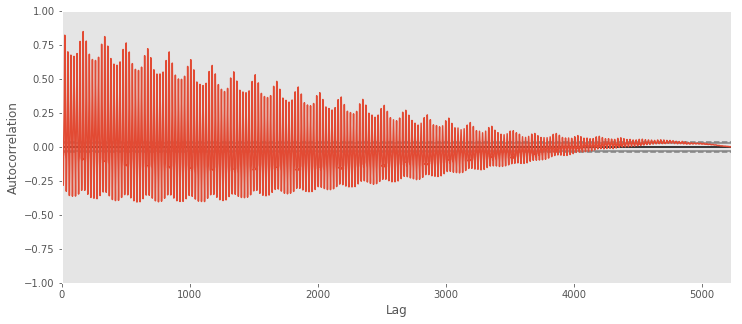

In [28]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(df_bixi_byhour)

<Figure size 216x576 with 0 Axes>

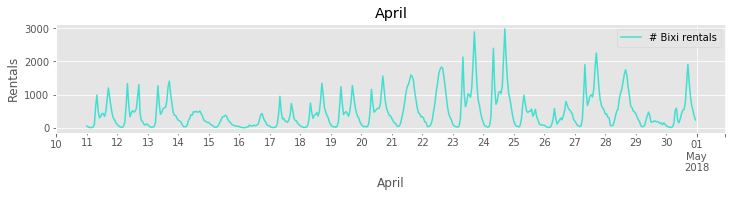

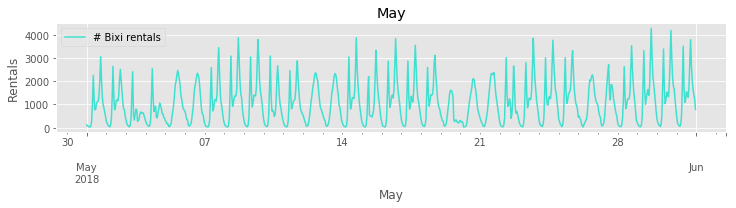

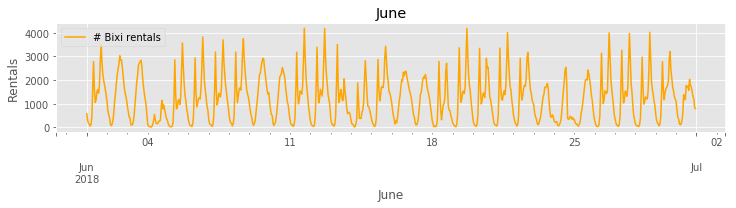

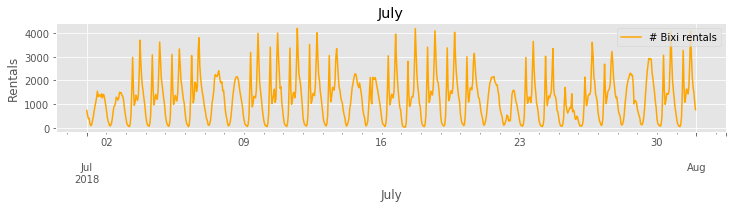

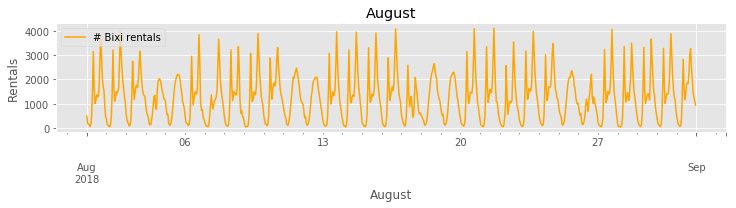

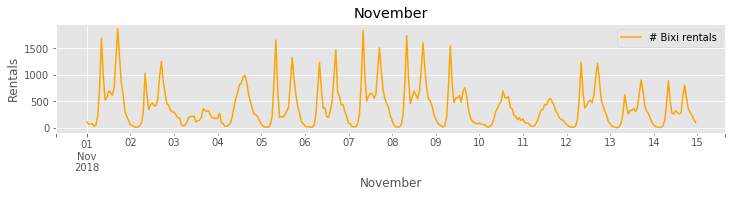

In [29]:
fig = plt.figure(figsize=(3,8))

ax = df_bixi_byhour['04-2018'].plot(color='turquoise', figsize = (12,2))
ax2 = df_bixi_byhour['05-2018'].plot(color='turquoise', figsize = (12,2))
ax3 = df_bixi_byhour['06-2018'].plot(color='orange', figsize = (12,2))
ax4 = df_bixi_byhour['07-2018'].plot(color='orange', figsize = (12,2))
ax5 = df_bixi_byhour['08-2018'].plot(color='orange', figsize = (12,2))
ax6 = df_bixi_byhour['11-2018'].plot(color='orange', figsize = (12,2))

ax.set_xlabel('April')
ax.set_ylabel('Rentals')
ax.set_title ('April')

ax2.set_xlabel('May')
ax2.set_ylabel('Rentals')
ax2.set_title ('May')

ax3.set_xlabel('June')
ax3.set_ylabel('Rentals')
ax3.set_title('June')

ax4.set_xlabel('July')
ax4.set_ylabel('Rentals')
ax4.set_title('July')

ax5.set_xlabel('August')
ax5.set_ylabel('Rentals')
ax5.set_title('August')

ax6.set_xlabel('November')
ax6.set_ylabel('Rentals')
ax6.set_title('November')

plt.show()

### Decomposition

<function matplotlib.pyplot.show(*args, **kw)>

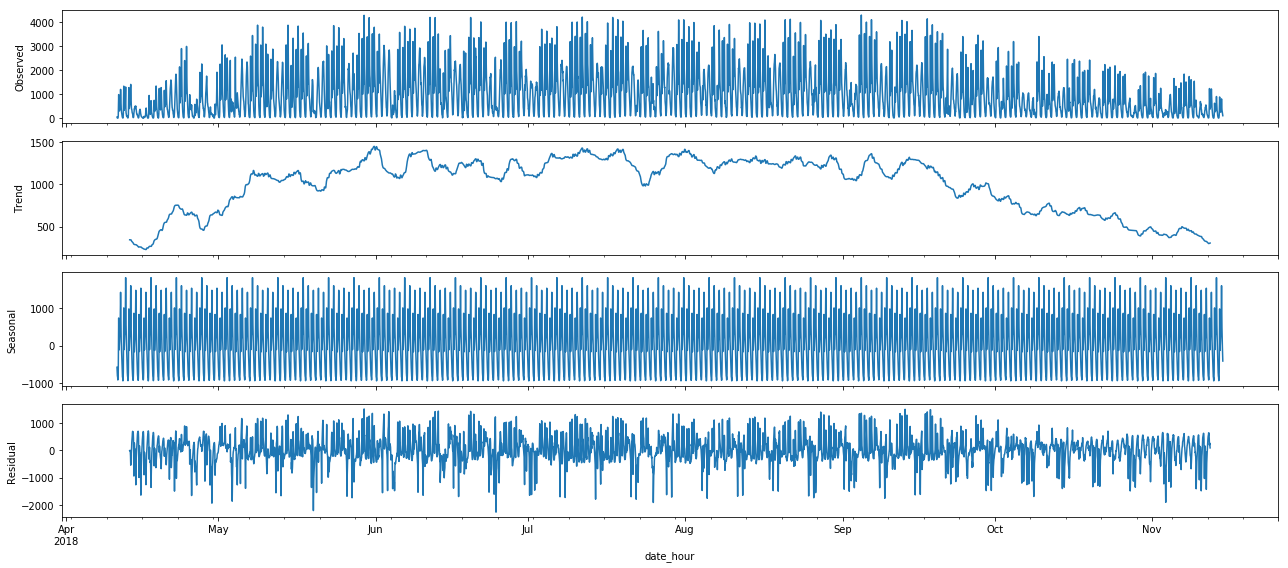

In [80]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = 18, 8

decomposition = seasonal_decompose(df_bixi_byhour, model='additive', freq=5*24)
ax = decomposition.plot()
plt.show

In [128]:
from statsmodels.tsa.stattools import adfuller
X = df_bixi_byhour.diff(periods=24)['04-2018'].dropna().values.flatten()
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.074599
p-value: 0.001067
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


<function matplotlib.pyplot.show(*args, **kw)>

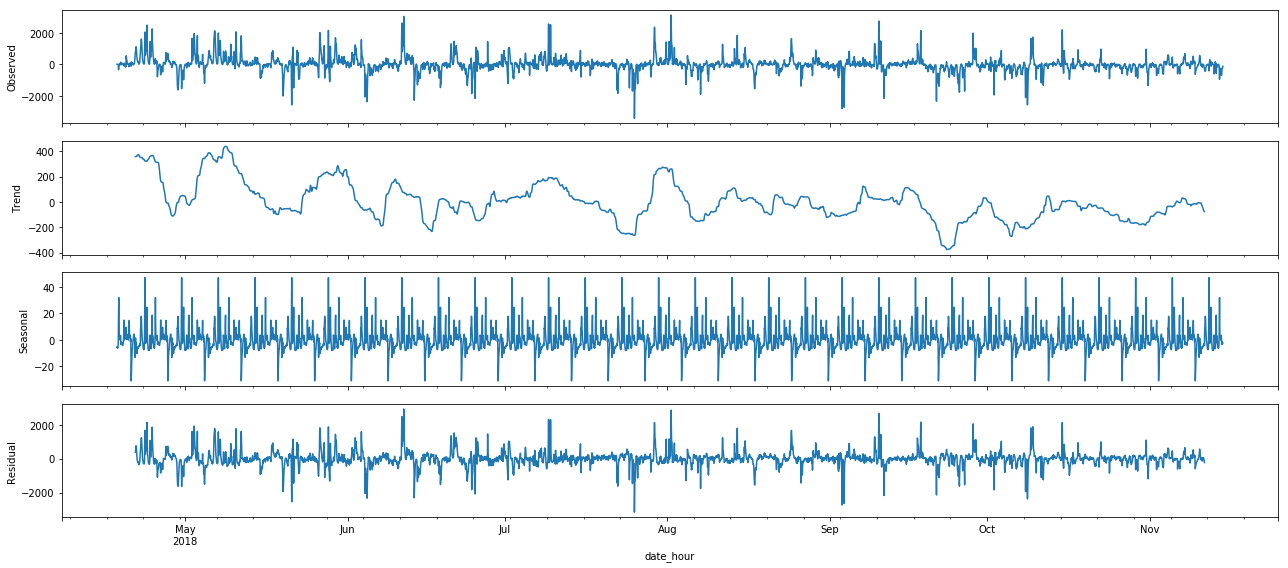

In [170]:
#To get rid of seasonality, difference by taking differences of exactly 1 week

decomp = seasonal_decompose(df_bixi_byhour.diff(periods = 24*7).dropna(), model='additive', freq=24*7)
ax99 = decomp.plot()
plt.show

In [199]:
# Seasonality seems to be present as patterns seem to repeat every 7 days.
# It makes sense to compare the same day of the week at the same hour to remove seasonality.
def stationarity_check(df):
    rolmean = df.dropna().rolling(window = 24*7).mean()
    rolstd = df.rolling(window = 24*7, center = False).std()
    
    fig = plt.figure(figsize=(18,10))
    orig = plt.plot(df.dropna(), color='teal',label='Original')
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    X = df.dropna().values.flatten()
    result = adfuller(X)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

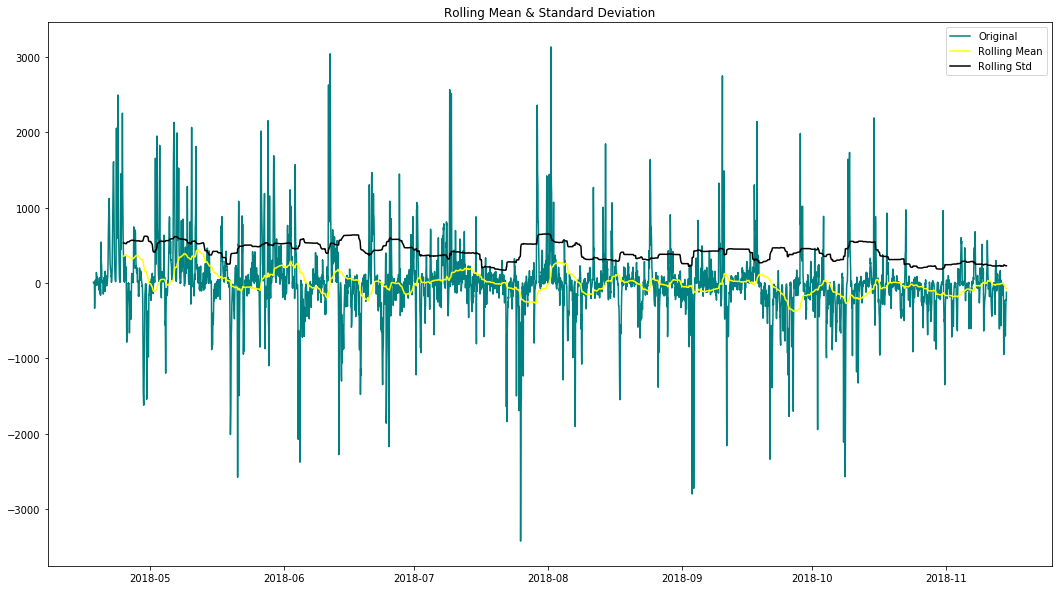

ADF Statistic: -9.161933
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [200]:
stationarity_check(df_bixi_byhour.diff(periods = 24*7))

<function matplotlib.pyplot.show(*args, **kw)>

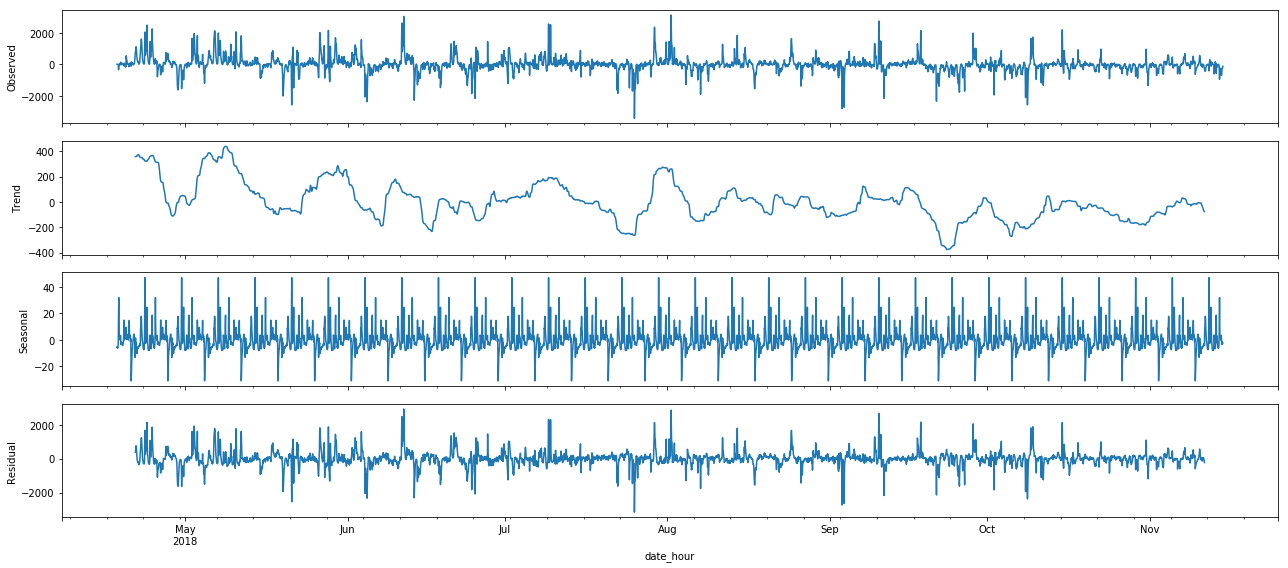

In [180]:
decomp = seasonal_decompose(df_bixi_byhour.diff(periods = 24*7).dropna(), model='additive', freq=24*7)
ax = decomp.plot()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

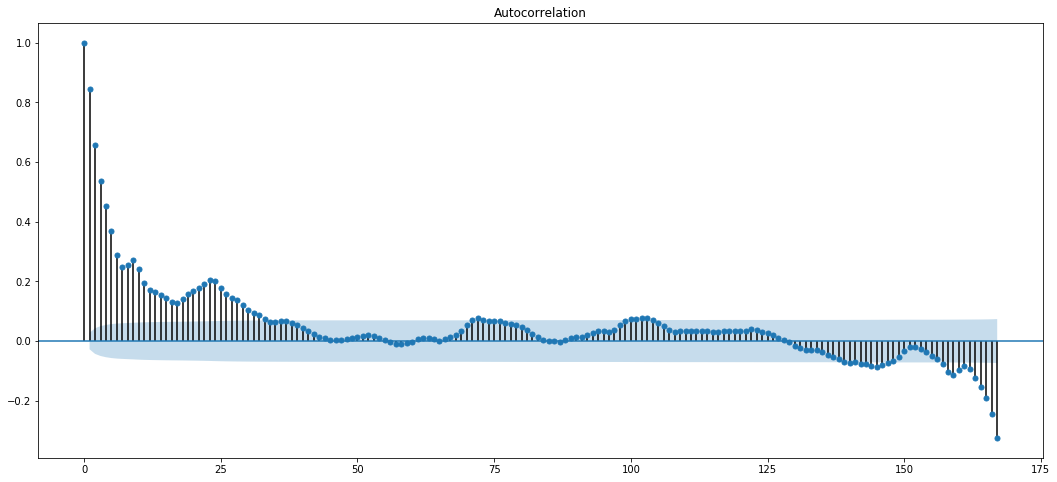

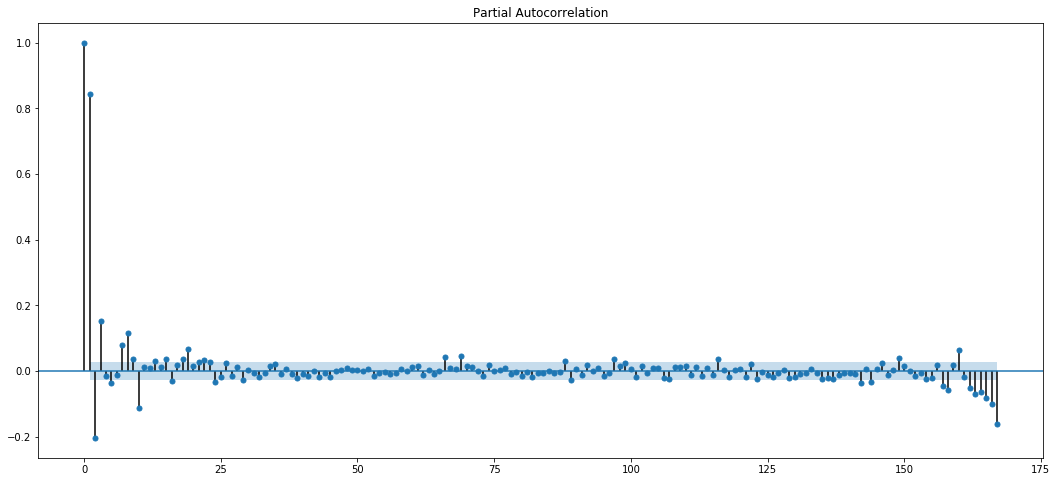

In [186]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

ax = plot_acf(X, lags = np.arange(24*7))
ax = plot_pacf(X, lags = np.arange(24*7))
plt.show

In [177]:
# import itertoolstools
# p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [178]:
# mod = sm.tsa.statespace.SARIMAX(df_bixi_byhour,
#                                 order=(1, 1, 1),
#                                 seasonal_order=(1, 1, 0, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# results = mod.fit()
# print(results.summary().tables[1])

## Algo options

#### Fast Fourier Transformation  (FFT algorithm) : 

- run FFT decomposition on input data
- decomposition into different sin functions and adding them gives original time series
- filter null amplitude or high frequency components (Noise because high frequency & irregularly)
- we have bunch of sinoid functions, keep the most significant
- recombine them & forecast
- https://www.youtube.com/watch?v=VYpAodcdFfA

#### Deep Learning - because of weather or event in the city that will hike up the demand